# Table of Contents
<hr>

[1. Load Data](#data_2)  
[2. Split the Dataset Into Train and Test](#split_1)  
[3. Balance the Target Class With Smote](#smote_1)  
[4. Feature Scaling](#scaling_1)  
[5. Baseline Modelling](#modelling_1)  

    - Logistic Regression  
    - XGBoost  
    - Dense Network  
[6. Results](#results_1)  


## 1. Load the Data <a name="data_2"> </a>
<hr>

In [59]:
import pandas as pd
import numpy as np

In [18]:
# specify the path for a parquet file
file_path = 'datasets/network_df.parquet'

In [19]:
# read the parquet file
df = pd.read_parquet(file_path, engine = 'pyarrow')

In [20]:
# check the content
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2160668 entries, 0 to 2160667
Data columns (total 18 columns):
 #   Column            Dtype  
---  ------            -----  
 0   PKT_SIZE          int64  
 1   FLAGS             int64  
 2   FID               int64  
 3   SEQ_NUMBER        int64  
 4   NUMBER_OF_PKT     int64  
 5   BYTE_RATE         float64
 6   UTILIZATION       float64
 7   PKT_DELAY         float64
 8   PKT_RESEVED_TIME  float64
 9   LAST_PKT_RESEVED  float64
 10  PKT_CLASS         int64  
 11  pkt_type__ping    int64  
 12  to__Router        int64  
 13  to__Server        int64  
 14  to__Switch        int64  
 15  from__Router      int64  
 16  from__Server      int64  
 17  from__Switch      int64  
dtypes: float64(5), int64(13)
memory usage: 296.7 MB


## 2. Split the Dataset Into Train and Test <a name="split_1"> </a>
<hr>

In [21]:
X=df.drop(columns='PKT_CLASS')
y=df['PKT_CLASS']

In [22]:
from sklearn.model_selection import train_test_split

# The stratify parameter ensures that the proportion of class labels (target values) is the same in both the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=34, stratify=y)

## 3. Balance the Target Class With Smote <a name = "smote_1"></a>
<hr>

Since the dataset is imbalanced (90/10), we will use Synthetic Minority Over-sampling Technique (SMOTE) to generate synthetic samples for the minority class.

In [23]:
from imblearn.over_sampling import SMOTE

# Define the SMOTE
smote = SMOTE(random_state=42)

# Fit and apply the undersampler to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
# Now X_train_resampled and y_train_resampled contain the balanced dataset

In [24]:
X_train.shape # initial training dataset

(1512467, 17)

In [25]:
X_train_smote.shape # oversampled training dataset

(2710342, 17)

In [26]:
y_train_smote.shape # oversampled target value

(2710342,)

In [27]:
y_train_smote.value_counts() #number of positive and negative classes is equal after oversampling

PKT_CLASS
0    1355171
1    1355171
Name: count, dtype: int64

## 4. Feature Scaling <a name="scaling_1"> </a>
<hr>

We will use Standard Scaler to normalize features scales.

In [28]:
from sklearn.preprocessing import StandardScaler


# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data
scaler.fit(X_train_smote)

# Transform both the training and testing data using the fitted scaler
X_train_scaled = scaler.transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)  # Use the same scaler fitted on X_train

## 5. Baseline Modelling <a name="modelling_1"> </a>
<hr>

We will start with training baseline models using Logistic Regression, XGBoost and Dense Neural Network (Fully Connected). We will not apply any fine-tuning just yet and will do that at the next stage. 

### Logistic Regression

In [287]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score
import time

In [314]:
# Initialize the logistic regression model
model_logreg = LogisticRegression(n_jobs=-1, random_state=42)

start = time.time()

# Train the model
model_logreg.fit(X_train_scaled, y_train_smote)

end=time.time()
print(end-start, "seconds")

4.5554280281066895 seconds


In [315]:
#Predict on the training set
y_train_logreg = model_logreg.predict(X_train_scaled)

# Calculate accuracy, recall, f1 and roc_auc for training dataset
accuracy_train = accuracy_score(y_train_smote, y_train_logreg)
recall_train = recall_score(y_train_smote, y_train_logreg)
f1_train = f1_score(y_train_smote, y_train_logreg)
roc_auc_train = roc_auc_score(y_train_smote, y_train_logreg)

print("Train Accuracy:", accuracy_train)
print("Train Recall:", recall_train)
print("Train F1-score:", f1_train)
print("Train ROC AUC Score:", roc_auc_train)

Train Accuracy: 0.9732782800104194
Train Recall: 0.9468362295238018
Train F1-score: 0.9725525121509848
Train ROC AUC Score: 0.9732782800104194


In [316]:
# Make predictions on the test set
y_test_logreg = model_logreg.predict(X_test_scaled)

In [317]:
# Calculate accuracy
accuracy_logreg = accuracy_score(y_test, y_test_logreg)

# Calculate recall
recall_logreg = recall_score(y_test, y_test_logreg)

# Calculate F1 score
f1_logreg = f1_score(y_test, y_test_logreg)


In [320]:
# Calculate ROC AUC score
y_proba = model_logreg.predict_proba(X_test_scaled)[:,1] # get the probabilites of belonging to either classes, prob of positive class is in column 1
roc_auc_logreg = roc_auc_score(y_test, y_proba)

In [321]:
print("Test Accuracy:", accuracy_logreg)
print("Test Recall:", recall_logreg)
print("Test F1-score:", f1_logreg)
print("Test ROC AUC Score:", roc_auc_logreg)

Test Accuracy: 0.9866414892911304
Test Recall: 0.8735703796003739
Test F1-score: 0.931516383394364
Test ROC AUC Score: 0.9365239340739413


In [322]:
# probablity distribution looks like this
model_logreg.predict_proba(X_test_scaled)

array([[0.94775119, 0.05224881],
       [0.94067847, 0.05932153],
       [0.95812886, 0.04187114],
       ...,
       [0.94834981, 0.05165019],
       [0.94712805, 0.05287195],
       [0.95335795, 0.04664205]])

#### Interpretation

In [323]:
# Coefficients of the features
coef = model_logreg.coef_[0]

In [324]:
# Corresponding feature names
feature_names = X_train.columns

# Create a DataFrame to display coefficients and their significance
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coef})
print(coef_df)

             Feature  Coefficient
0           PKT_SIZE     0.110440
1              FLAGS     0.025457
2                FID    -0.242378
3         SEQ_NUMBER    -0.072130
4      NUMBER_OF_PKT     1.385330
5          BYTE_RATE     4.324432
6        UTILIZATION    -4.021844
7          PKT_DELAY     1.618169
8   PKT_RESEVED_TIME     0.037057
9   LAST_PKT_RESEVED    -2.310476
10    pkt_type__ping    -0.385053
11        to__Router     3.333563
12        to__Server    -0.481472
13        to__Switch    -3.917078
14      from__Router    -3.425475
15      from__Server    -6.520208
16      from__Switch    -7.325202


We will use <b>statsmodels</b> to interpret the coefficients and their significance

In [325]:
# Interpret coefficients and p-value using stats models
import statsmodels.api as sm

logreg_stat = sm.Logit(y_train_smote, sm.add_constant(X_train_scaled)) # Add a constant term for the intercept
result = logreg_stat.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.107567
         Iterations 14
                           Logit Regression Results                           
Dep. Variable:              PKT_CLASS   No. Observations:              2710342
Model:                          Logit   Df Residuals:                  2710324
Method:                           MLE   Df Model:                           17
Date:                Wed, 26 Jun 2024   Pseudo R-squ.:                  0.8448
Time:                        13:03:13   Log-Likelihood:            -2.9154e+05
converged:                       True   LL-Null:                   -1.8787e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5160      0.052     87.625      0.000       4.415       4.617
x1             0.0175      0

In [326]:
# Extract coefficients and p-values
result_summary = result.summary().tables[1].data

# Create a DataFrame to store coefficients and their p-values
result_summary = pd.DataFrame(result_summary[1:], columns=['Features','Coefficient', 'Standard Error', 'Z-value', 'P-value', 'Lower CI', 'Upper CI'])
result_summary.iloc[1:, 0] = X_train.columns
# Convert coefficient and p-value columns to numeric
result_summary['Coefficient'] = pd.to_numeric(result_summary['Coefficient'])
result_summary['P-value'] = pd.to_numeric(result_summary['P-value'])

# Print the DataFrame
print(result_summary)

            Features  Coefficient Standard Error    Z-value  P-value  \
0              const       4.5160          0.052     87.625     0.00   
1           PKT_SIZE       0.0175          0.034      0.510     0.61   
2              FLAGS       0.0260          0.003     10.206     0.00   
3                FID      -0.2506          0.009    -27.460     0.00   
4         SEQ_NUMBER      -0.0646          0.004    -17.153     0.00   
5      NUMBER_OF_PKT       1.4169          0.015     96.097     0.00   
6          BYTE_RATE       2.6064          0.081     31.984     0.00   
7        UTILIZATION      -3.5976          0.023   -156.687     0.00   
8          PKT_DELAY       1.6243          0.012    140.451     0.00   
9   PKT_RESEVED_TIME       0.0312          0.005      5.897     0.00   
10  LAST_PKT_RESEVED      -2.3587          0.026    -89.097     0.00   
11    pkt_type__ping      -0.2962          0.019    -15.212     0.00   
12        to__Router       3.4176          0.026    130.015     

In [327]:
results_df=result_summary[['Features', 'Coefficient', 'P-value']] # select columns of interest

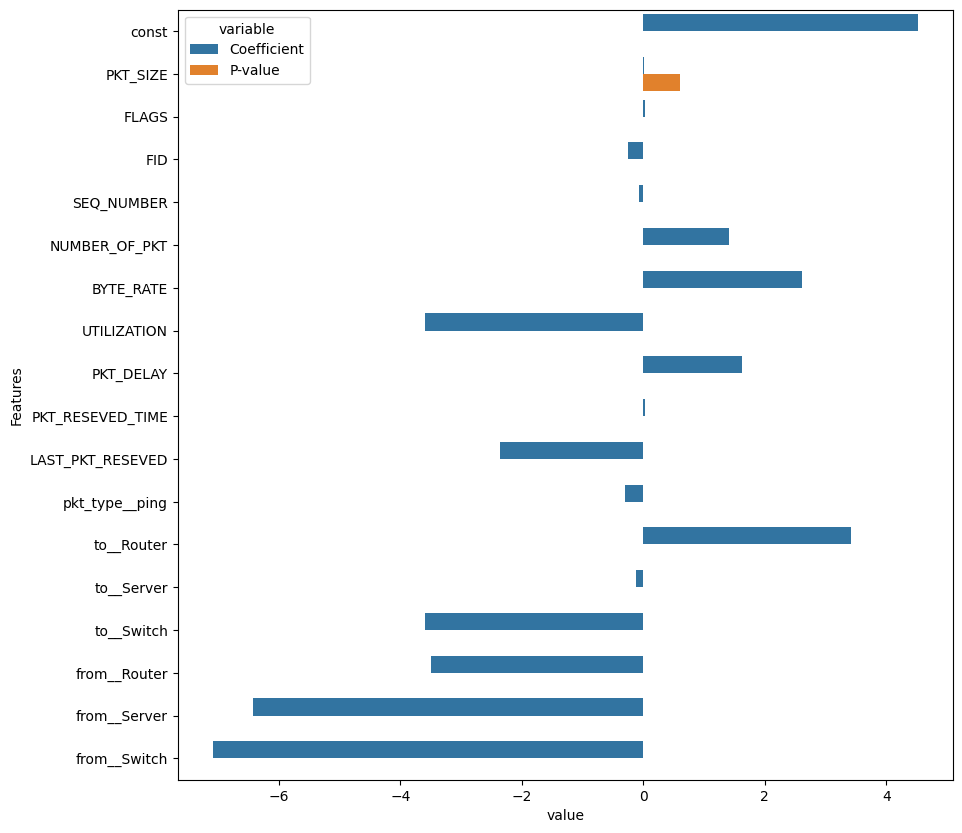

In [330]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot magnitude of features and their significance
plt.subplots(figsize=(10, 10))
sns.barplot(x='value', y='Features',hue='variable', data=pd.melt(results_df, id_vars='Features') )
plt.show()

<b> PKT_SIZE, NUMBER_OF_PKT, BYTE_RATE, UTILIZTION, PLT_DELAY, LAST_PKT_RESEVED </b> and packets directed to or from network devices had big effect on the model. PKT_SIZE's P-value is way bigger than 0.05, so this feature might not make statistically significant difference.

#### Evaluation

#### Confusion Matrix

In [331]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_test_logreg)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix,
    columns=["Predicted Normal Traffic", "Predicted Malicious Traffic"],
    index=["True Normal Traffic", "True Malicious Traffic"]
)

<Axes: >

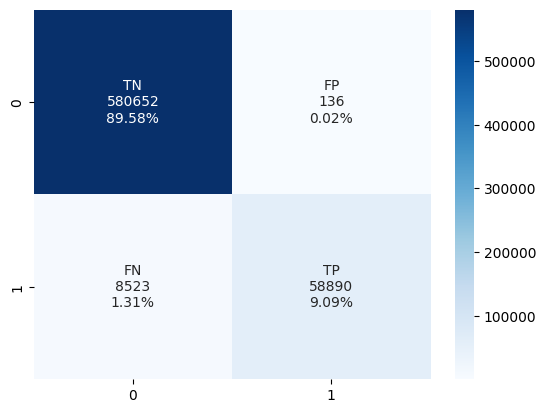

In [332]:
import numpy as np
group_names = ['TN','FP','FN','TP']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

FN rate is quite high. ***The FN is of high importance as it's accountable to showcase amount of malicious traffic that were marked as normal.*** Let's closer see the metrics of the positive class.

In [333]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# First calculate precision and recall using the default (0.5) cut-off
y_threshold = np.where(y_proba > 0.5, 1, 0)

In [334]:
print("Threshold of 0.5:")
print(f"Accuracy score: {accuracy_score(y_test, y_threshold)}")
print(f"Precision score: {precision_score(y_test, y_threshold)}")
print(f"Recall score: {recall_score(y_test, y_threshold)}")
print(f"F1-score: {f1_score(y_test, y_threshold)}")
print("")

Threshold of 0.5:
Accuracy score: 0.9866414892911304
Precision score: 0.9976959306068512
Recall score: 0.8735703796003739
F1-score: 0.931516383394364



Recall score is <b>87.35%</b> which represents the proportion of actual positive cases that were correctly identified out of all actual positive cases in the dataset.

#### Playing with Probability Thresholds for Hard Prediction

While default hard prediction threshold is 0.5, we will be seeing how the Recall and Precision rates change when various thresholds used.

In [335]:
from sklearn.metrics import accuracy_score

# Vary thresholds by 0 from 0.05 to 0.95
thresholds = np.arange(0, 0.99, 0.05)

precisions = list()
recalls = list()

start=time.time()
for threshold in thresholds:

    # Apply threshold
    y_threshold = np.where(y_proba > threshold, 1, 0)

    # Calculate precision and recall
    precision = precision_score(y_test, y_threshold)
    recall = recall_score(y_test, y_threshold)
    
    # Append to list
    precisions.append(precision)
    recalls.append(recall)
    
end=time.time()
print (end-start, "seconds")

3.8103930950164795 seconds


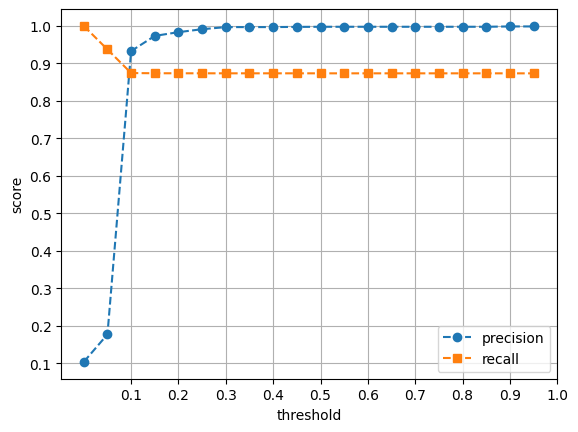

In [336]:
# Visualize the result
plt.figure()
plt.plot(thresholds, precisions, label='precision',marker='o', linestyle ='--')
plt.plot(thresholds, recalls, label='recall', marker='s', linestyle='--')
plt.xlabel('threshold')
plt.ylabel('score')

# Adjusting x-axis and y-axis ticks to increments of 0.1
plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5,0.6,0.7,0.8,0.9,1])  # Set x-axis ticks explicitly
plt.yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])  # Set y-axis ticks explicitly

plt.grid(True)
plt.legend()
plt.show()

Any probability threshold <font color='red'>between ~ 0.1 and ~ 0.95 </font> gives the same precision and recall rates. So, updating the <font color='red'>threshold</font> **would not give us better recall rate**.  

#### Receiver Operating Charecterisitc (ROC) and Area Under The Curve (AUC)

***The True Positive Rate (TPR)*** measures what proportion of a model assigned to positive are actually members of the positive class:

In [337]:
#y_proba = baseline_logreg.predict_proba(X_test_scaled)[:,1]
y_binary = np.where(y_proba > 0.5, 1, 0)

TPR = recall_score(y_test, y_binary)
print(f"TPR: {TPR}")

TPR: 0.8735703796003739


TPR and Recall are the same concepts.

The ***False Positive Rate (FPR)*** will be the proportion of all negatives that incorrectly identified as positive, that is:

In [338]:
# helprer function to determin FPR
def false_positive_rate(y_true, y_pred):

    false_positives = (y_true == 0) & (y_pred== 1) # find all values where y is negative
                                                    # but we predicted positive
    false_positive_number = false_positives.sum()

    true_negatives = (y_true == 0) & (y_pred == 0)  # find all values where y is negative
                                                    # and we predicted negative
    true_negative_number = true_negatives.sum()

    # Finally, find the ratio of (FP) to (TN + FP)
    FPR = false_positive_number/(true_negative_number + false_positive_number)

    return FPR

In [339]:
#y_proba = baseline_logreg.predict_proba(X_test_scaled)[:,1]
y_binary = np.where(y_proba > 0.5, 1, 0)

FPR = false_positive_rate(y_test, y_binary)
print(f"FPR: {FPR}")

FPR: 0.00023416461772626156


In [340]:
thresholds = np.linspace(0, 1, 100)

# Iterate over the thresholds and compute the positive and negative recall
true_positive_rates = []
false_positive_rates = []

thresholds = np.linspace(0, 1, 50)
for threshold in thresholds:

    # Apply the cutoff and calculate the positive and negative recall
    y_pred = np.where(y_proba > threshold, 1, 0)

    tpr = recall_score(y_test, y_pred)
    fpr = false_positive_rate(y_test, y_pred)

    true_positive_rates.append(tpr)
    false_positive_rates.append(fpr)

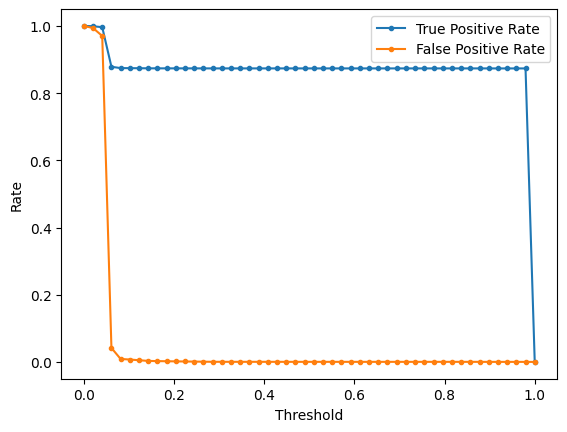

In [341]:
plt.figure()
plt.plot(thresholds, true_positive_rates, label='True Positive Rate', marker='.')
plt.plot(thresholds, false_positive_rates, label='False Positive Rate', marker='.')
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.legend()
plt.show()

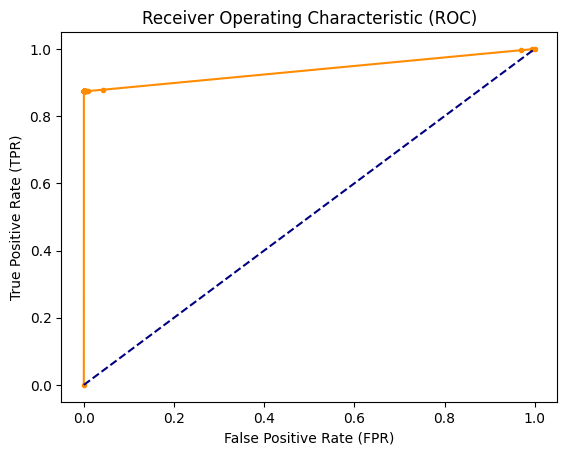

In [342]:
# True positive rate (TPR) = recall
tprs = np.array(true_positive_rates)

# False positive rate (FPR)
fprs = np.array(false_positive_rates)

plt.figure()
plt.plot(fprs, tprs, color='darkorange', marker='.')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.show()

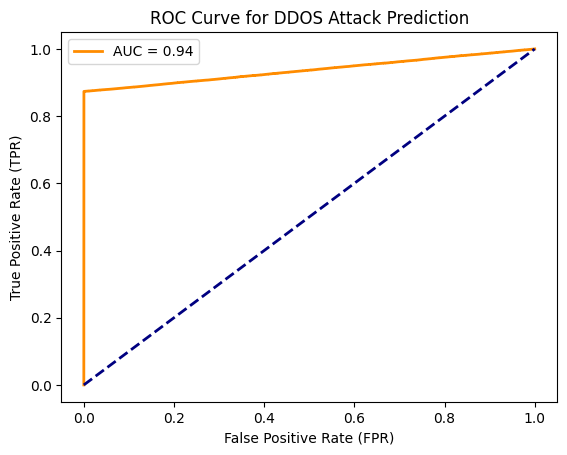

Area under curve (AUC):0.9365239340739413



In [48]:
from sklearn.metrics import roc_curve, roc_auc_score

fprs, tprs, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure()
plt.plot(fprs, tprs, color='darkorange',
         lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for DDOS Attack Prediction')
plt.legend(loc="best")
plt.show()

print(f'Area under curve (AUC):{roc_auc}')
print()

It indicates that the model is very effective at distinguishing between the positive and negative classes, ***with a high true positive rate (TPR) and a low false positive rate (FPR)***.

An AUC value of `0.94` indicates the probability of ranking a randomly chosen positive instance higher than a randomly chosen negative instance.

**Summary of baseline model evaluation:**

* Accuracy is 98.66%
* Recall is 87.36%
* AUC score is 93.65%
* F1 score is 93.15%

### XGBoost

In [344]:
import time
import numpy as np

start=time.time()

from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

model_xgb = XGBClassifier(n_jobs=-1)

# Define the list of scoring metrics
scoring = ['accuracy', 'recall']

model_xgb.fit(X_train_scaled, y_train_smote)

end=time.time()
print(end-start, "seconds")

3.974717140197754 seconds


In [345]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, precision_score
# Predict on the training set
y_xgb_train = model_xgb.predict(X_train_scaled)

# Calculate accuracy, recall, and other metrics
accuracy_train = accuracy_score(y_train_smote, y_xgb_train)
recall_train = recall_score(y_train_smote, y_xgb_train)
f1_train = f1_score(y_train_smote, y_xgb_train)
roc_auc_train = roc_auc_score(y_train_smote, y_xgb_train)

print("Train Accuracy:", accuracy_train)
print("Train Recall:", recall_train)
print("Train F1-score:", f1_train)
print("Train ROC AUC Score:", roc_auc_train)

Train Accuracy: 0.9857962574464773
Train Recall: 0.9717467389724249
Train F1-score: 0.9855938580895668
Train ROC AUC Score: 0.9857962574464774


In [346]:
y_xgb_test = model_xgb.predict(X_test_scaled)

# Calculate accuracy, recall, and other metrics
accuracy_xgboost = accuracy_score(y_test, y_xgb_test)
recall_xgboost = recall_score(y_test, y_xgb_test)
f1_xgboost = f1_score(y_test, y_xgb_test)
roc_auc_xgboost = roc_auc_score(y_test, y_xgb_test)

print("Train Accuracy:", accuracy_xgboost)
print("Train Recall:", recall_xgboost)
print("Train F1-score:", f1_xgboost)
print("Train ROC AUC Score:", roc_auc_xgboost)

Train Accuracy: 0.986717083126993
Train Recall: 0.8735703796003739
Train F1-score: 0.9318775219558509
Train ROC AUC Score: 0.9367102915584877


### Dense Neural Network

In [32]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

In [33]:
X_train_scaled.shape

(2710342, 17)

In [34]:
# Create a new sequential model
model = keras.Sequential([Input(shape=(X_train_scaled.shape[1],))])

# Declare the hidden layers (2 layers with 16 nodes each)
for i in range (0, 2):
    model.add(layers.Dense(10, activation="tanh"))
    model.add(layers.BatchNormalization())
# Declare the output layer
model.add(layers.Dense(1, activation="sigmoid"))

In [44]:
import time
start = time.time()
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='binary_crossentropy', 
              metrics=[keras.metrics.Recall(),keras.metrics.BinaryAccuracy()]
             )

# fit model
history = model.fit(X_train_scaled, y_train_smote,
                    batch_size=512,
                    validation_data=(X_test_scaled, y_test), 
                    epochs=4,
                    verbose=1)
                    
end = time.time()

print (end-start, "seconds")

Epoch 1/4
5294/5294 [==============================] - 5s 797us/step - loss: 0.1056 - recall_2: 0.9468 - binary_accuracy: 0.9733 - val_loss: 0.0874 - val_recall_2: 0.8735 - val_binary_accuracy: 0.9867
Epoch 2/4
5294/5294 [==============================] - 4s 741us/step - loss: 0.1055 - recall_2: 0.9468 - binary_accuracy: 0.9733 - val_loss: 0.0874 - val_recall_2: 0.8735 - val_binary_accuracy: 0.9867
Epoch 3/4
5294/5294 [==============================] - 4s 748us/step - loss: 0.1055 - recall_2: 0.9468 - binary_accuracy: 0.9733 - val_loss: 0.0880 - val_recall_2: 0.8735 - val_binary_accuracy: 0.9867
Epoch 4/4
5294/5294 [==============================] - 4s 741us/step - loss: 0.1054 - recall_2: 0.9468 - binary_accuracy: 0.9733 - val_loss: 0.0871 - val_recall_2: 0.8735 - val_binary_accuracy: 0.9867
16.903839826583862 seconds


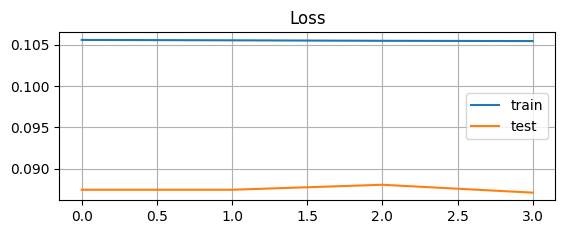

In [45]:
import matplotlib.pyplot as plt
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.grid()
plt.legend()

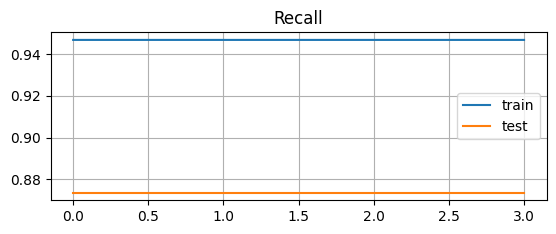

In [46]:
# plot accuracy during training
plt.subplot(212)
plt.title('Recall')
plt.plot(history.history['recall_2'], label='train')
plt.plot(history.history['val_recall_2'], label='test')
plt.legend()
plt.grid()
plt.show()

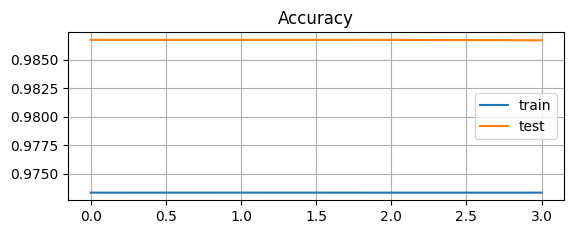

In [47]:
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['binary_accuracy'], label='train')
plt.plot(history.history['val_binary_accuracy'], label='test')
plt.legend()
plt.grid()
plt.show()

#### Evaluate the Model

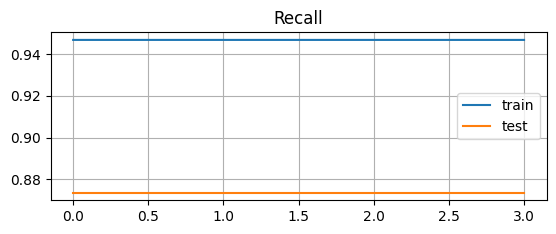

In [48]:
# plot accuracy during training
plt.subplot(212)
plt.title('Recall')
plt.plot(history.history['recall_2'], label='train')
plt.plot(history.history['val_recall_2'], label='test')
plt.legend()
plt.grid()
plt.show()

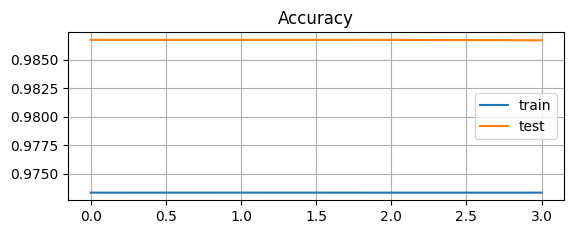

In [49]:
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['binary_accuracy'], label='train')
plt.plot(history.history['val_binary_accuracy'], label='test')
plt.legend()
plt.grid()
plt.show()

In [53]:
# Evaluate the network
train_accuracy = history.history['binary_accuracy'][-1]
dense_accuracy = history.history['val_binary_accuracy'][-1]

train_recall = history.history['recall_2'][-1]
dense_recall = history.history['val_recall_2'][-1]

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {dense_accuracy:.4f}")

print(f"Train Recall: {dense_recall:4f}")
print(f"Test Recall: {dense_recall:4f}")

Train Accuracy: 0.9733
Test Accuracy: 0.9867
Train Recall: 0.873541
Test Recall: 0.873541


In [57]:
# Calculate ROC-AUC
# Make predictions
from sklearn.metrics import roc_auc_score, f1_score

y_pred_prob = model.predict(X_test_scaled).ravel()
dense_roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f'Test ROC-AUC: {dense_roc_auc:.4f}')

20257/20257 [==============================] - 6s 317us/step
Test ROC-AUC: 0.9367


In [63]:
# Apply the cutoff and calculate the positive and negative recall
y_pred = np.where(y_pred_prob > 0.5, 1, 0)

# Calculate F1 score
f1_dense = f1_score(y_test, y_pred)
print(f'Test F1 Score: {f1_dense:.4f}')

Test F1 Score: 0.9319


In [64]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

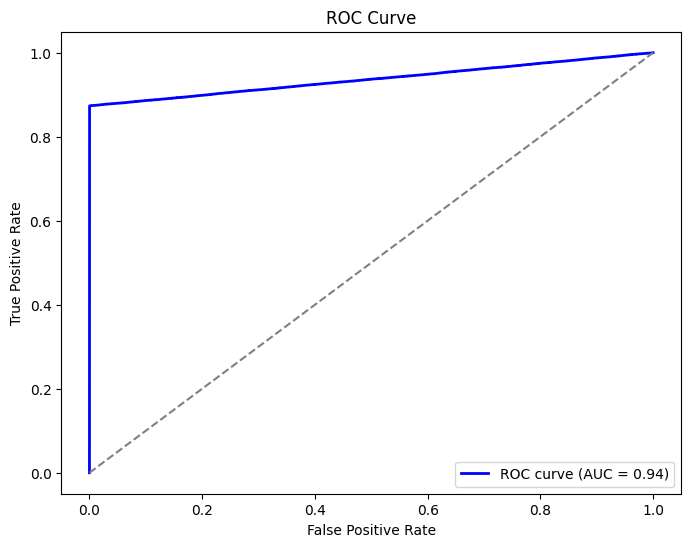

In [67]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {dense_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

## 6. Results <a name="results"> </a>
<hr>

Due to class imbalance, recall-precision would be a preferred metric to compare models' performence. F1 metric will be used as the main metric to compare the models it combines precision and recall.

In [372]:
data = {'Model': ['LogReg','XGBoost', 'DenseNetwork'],
        'F1': [f1_logreg, f1_xgboost, f1_dense]
}

In [373]:
# Creat dataframe from dictionary
metrics_df = pd.DataFrame(data)

In [374]:
metrics_df

,Model,F1
0,LogReg,0.931516
1,XGBoost,0.931878
2,DenseNetwork,0.931927


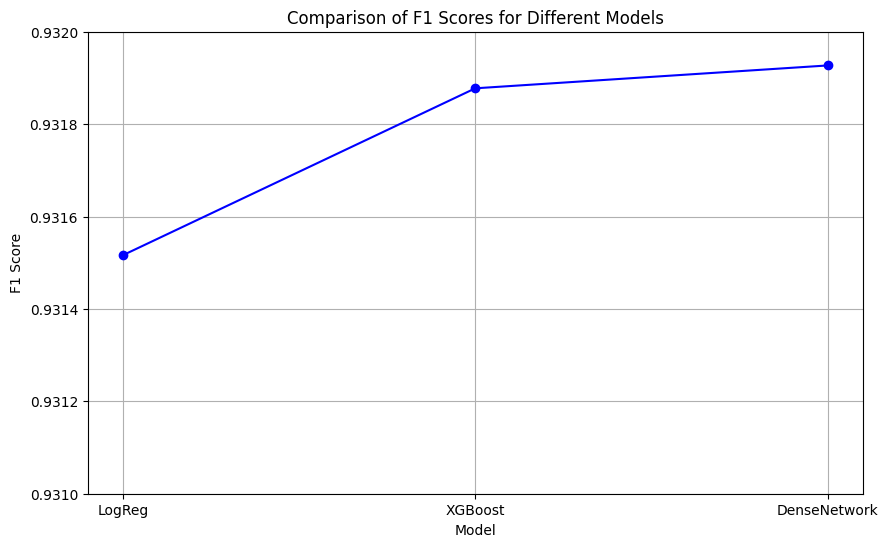

In [378]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Model'], metrics_df['F1'], marker='o', linestyle='-', color='b')

# Add labels and title
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('Comparison of F1 Scores for Different Models')
plt.ylim(0.931, 0.932)  # F1 scores range from 0 to 1

# Show the plot
plt.grid(True)
plt.show()

We see that without fine-tuning, DenseNetwork showed the highest F1 score.